In [1]:
import numpy as np
#####################################
import torch
import torch.nn as nn
#import torch.nn.functional as F
from torch import optim, autograd
#####################################
from matplotlib import pyplot as plt

In [3]:
def random_dom_points(n=4096,d=1):
    x = torch.rand(n,d)
    x.requires_grad = True
    return x
def random_bc_points(n=64):
    n_ = int(n/4)
    x1 = torch.rand(n_,1)
    y1 = torch.zeros(n_,1)
    #
    x2 = torch.ones(n_,1)
    y2 = torch.rand(n_,1)
    #
    x3 = torch.rand(n_,1)
    y3 = torch.ones(n_,1)
    #
    x4 = torch.zeros(n_,1)
    y4 = torch.rand(n_,1)
    x = torch.cat((x1,x2,x3,x4),0)
    y = torch.cat((y1,y2,y3,y4),0)
    aux = torch.cat((x,y),1)
    aux.requires_grad = True
    return aux

In [4]:
def f(x):
    
    aux = 2*(np.pi)**2*torch.sin(np.pi*x[:,0])*torch.sin(np.pi*x[:,1])
    return aux.view(-1,1)

In [5]:
device = 'cpu' #torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Is cuda available?',torch.cuda.is_available())
print('Used device:',device)

Is cuda available? False
Used device: cpu


In [6]:
epochs = 50000 #50000

in_N = 1
m = 10
out_N = 1

In [7]:
torch.manual_seed(42)
model = torch.nn.Sequential(
    nn.Linear(2,10),
    nn.Sigmoid(),
    nn.Linear(10,10),
    nn.Sigmoid(),
    nn.Linear(10,20),
    nn.Sigmoid(),    
    nn.Linear(20,20),
    nn.Sigmoid(),
    nn.Linear(20,20),
    nn.Sigmoid(),
    nn.Linear(20,10),
    nn.Sigmoid(),   
    nn.Linear(10,1)
)

In [8]:
model

Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=10, out_features=10, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=10, out_features=20, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=20, out_features=20, bias=True)
  (7): Sigmoid()
  (8): Linear(in_features=20, out_features=20, bias=True)
  (9): Sigmoid()
  (10): Linear(in_features=20, out_features=10, bias=True)
  (11): Sigmoid()
  (12): Linear(in_features=10, out_features=1, bias=True)
)

In [9]:
optimizer = optim.Adam(model.parameters(), lr=3e-3)

$$\mathcal{L}(u) = \int_{\Omega} |\nabla u|^2 - fu\,dx + \alpha \int_{\partial \Omega} \left(u - bc\right)^2\,dS$$

In [10]:
best_loss, best_epoch = 1000, 0
loss_vector = []
for epoch in range(epochs+1):
    # Clear previous gradient computation
    optimizer.zero_grad()
    # Random interior points
    x   = random_dom_points(d=2)
    u   = model(x)
    # Gradient computation 
    u_x = autograd.grad(outputs=u, 
                          inputs=x,
                          create_graph=True, 
                          grad_outputs=torch.ones_like(u)
                         )[0]
    # Loss function (1st component)
    loss1 = torch.mean(0.5*(u_x[:,0]**2 + u_x[:,1]**2) - f(x)*u)
    # Loss function (2nd component)
    x_bc = random_bc_points()
    u_bc = model(x_bc)
    loss2 = torch.mean((u_bc - 0.)**2)
    # Loss function
    loss = loss1 + 500*loss2    
    # Backpropagation
    loss.backward()
    # ANN's weights update
    optimizer.step()
    #
    loss_vector.append(loss.item())
    #
    if epoch % 5000 == 0:
        print('epoch:', epoch, 
              '\n loss      :', loss.item(), 
              '\n loss int  :', (loss1).item(), 
              '\n loss bound:', (loss2).item())
        if epoch > int(4 * epochs / 5):
            if torch.abs(loss) < best_loss:
                best_loss = torch.abs(loss).item()
                best_epoch = epoch
                torch.save(model.state_dict(), 'best_approx.mdl')
print('best epoch:', best_epoch, 'best loss:', best_loss)
#loss      : -2.3757529258728027 
#loss int  : -2.3814682960510254 
#loss bound: 1.143070767284371e-05

epoch: 0 
 loss      : 4.8645339012146 
 loss int  : 0.7237387895584106 
 loss bound: 0.008281590417027473
epoch: 5000 
 loss      : -2.3424160480499268 
 loss int  : -2.37495493888855 
 loss bound: 6.507755460916087e-05
epoch: 10000 
 loss      : -2.389768123626709 
 loss int  : -2.438560724258423 
 loss bound: 9.758521628100425e-05
epoch: 15000 
 loss      : -2.4929275512695312 
 loss int  : -2.573697805404663 
 loss bound: 0.00016154053446371108
epoch: 20000 
 loss      : -2.4027957916259766 
 loss int  : -2.4128427505493164 
 loss bound: 2.0093806597287767e-05
epoch: 25000 
 loss      : -2.5502853393554688 
 loss int  : -2.616311550140381 
 loss bound: 0.00013205260620452464
epoch: 30000 
 loss      : -2.450935125350952 
 loss int  : -2.5510239601135254 
 loss bound: 0.0002001778775593266
epoch: 35000 
 loss      : -2.2970664501190186 
 loss int  : -2.328294277191162 
 loss bound: 6.245577242225409e-05
epoch: 40000 
 loss      : -2.268110752105713 
 loss int  : -2.2898125648498535 

In [17]:
torch.save(model.state_dict(), 'best_approx_2D.mdl')

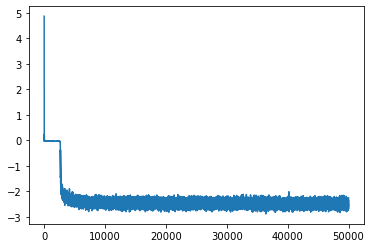

In [11]:
plt.plot(loss_vector)

In [12]:
#model.load_state_dict(torch.load('best_approx_2D.mdl'))

In [24]:
with torch.no_grad():
    x1 = torch.linspace(0.,1,100)
    x1 = x1.flatten()[:, None]
    x2 = 0.8*torch.ones_like(x1)    
    y_hat = model(torch.cat((x1,x2),1))
    y_real = torch.sin(np.pi*x1)*torch.sin(np.pi*x2)

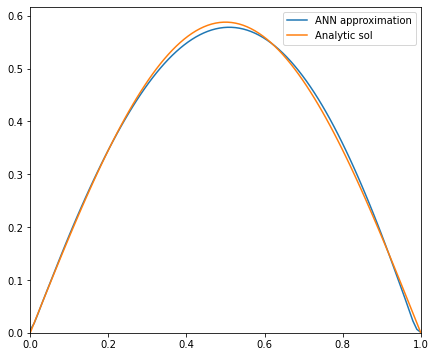

In [25]:
plt.figure(figsize=(7,6))
plt.plot(x1,y_hat,label='ANN approximation')
plt.plot(x1,y_real, label='Analytic sol')
#
plt.xlim(0,1)
plt.ylim(0,None)
#
plt.legend()